In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
import plotly.graph_objects as go
from tqdm import tqdm

In [2]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('data/5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
M = df['SSN'].max()
df['SSN'] = df['SSN'] / M
for i in range(1, 6):
    df[f'M{i}'] = df[f'M{i}'] / M

df.tail()

,year,month,decimal_date,SSN,M1,M2,M3,M4,M5
643,2018,8,2018.623,0.028768,0.028838,0.007422,0.071437,0.138527,0.159606
644,2018,9,2018.705,0.027909,0.029266,0.007966,0.073743,0.135698,0.167333
645,2018,10,2018.790,0.029197,0.029564,0.008762,0.075843,0.132842,0.176335
646,2018,11,2018.873,0.028768,0.030029,0.009605,0.078106,0.129633,0.184630
647,2018,12,2018.958,0.025762,0.030656,0.010354,0.080041,0.126078,0.192651


In [3]:
model_series = df['M1'].values
observed_series = df['SSN'].values

# make dates into datetime objects from year and month in format yyyy-mm
dates = pd.to_datetime(df[['year', 'month']].assign(day=1))
dates

0     1965-01-01
1     1965-02-01
2     1965-03-01
3     1965-04-01
4     1965-05-01
         ...    
643   2018-08-01
644   2018-09-01
645   2018-10-01
646   2018-11-01
647   2018-12-01
Length: 648, dtype: datetime64[ns]

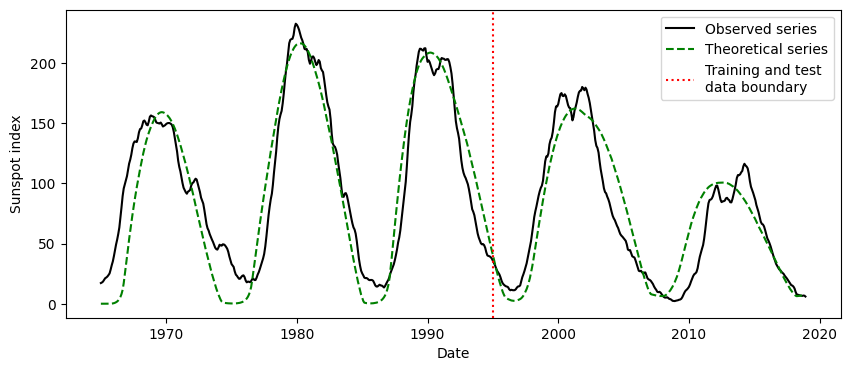

In [4]:
plt.figure(figsize=(10, 4))

plt.plot(dates, observed_series * M, label='Observed series', color='black')

plt.plot(dates, model_series * M, label=f'Theoretical series', linestyle='--', color='green')

# make vline at dates[360] to separate training and test data
plt.axvline(dates[360], color='r', linestyle=':', label='Training and test\ndata boundary')

plt.xlabel('Date')
plt.ylabel('Sunspot index')
plt.legend()
plt.savefig('imgs/plots_article/en/data.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

# x18

In [5]:
folder_path = 'weights_and_data/final/x18/rmses'
# filenames = os.listdir(folder_path)[:10]
# full_rmses = [np.load(os.path.join(folder_path, filename)) for filename in filenames]
# full_rmses = np.array(full_rmses)
# full_rmses.shape

In [6]:
# Определяем диапазоны iter и horizon
iters = range(100)  # от 11 до 99 включительно
horizons = range(1, 19)  # от 1 до 18 включительно

# Создаем пустой список для хранения массивов по каждому iter
iter_arrays = []

for i in iters:
    # Создаем список для хранения массива каждого horizon для текущего iter
    horizon_arrays = []
    
    for h in horizons:
        # Путь к файлу
        file_path = f'weights_and_data/final/x18/rmses/rmse_iter{i}_horizon{h}.npy'
        
        # Загрузка массива (размерность (20,))
        horizon_array = np.load(file_path)
        
        # Добавляем массив текущего horizon в список
        horizon_arrays.append(horizon_array)
    
    # Конкатенируем массивы по horizon, чтобы получить массив размера (20, 18) для текущего iter
    iter_array = np.stack(horizon_arrays, axis=1)
    
    # Добавляем массив текущего iter в общий список
    iter_arrays.append(iter_array)

# Конкатенируем массивы по iter, чтобы получить массив размера (90, 20, 18)
final_array = np.stack(iter_arrays, axis=0)

# Проверка финальной формы
print("Final array shape:", final_array.shape)


Final array shape: (100, 20, 18)


In [14]:
combined_rmses_array = np.concatenate([final_array, full_rmses], axis=0)
combined_rmses_array.shape

(100, 20, 18)

In [7]:
combined_rmses_array = final_array.copy()
mean_rmses_x18 = np.mean(combined_rmses_array, axis=0)
stds_x18 = np.std(combined_rmses_array, axis=0, ddof=1)


# auto & 18-forward

In [8]:
def load_rmses(folder_path):
    # Считывание всех файлов rmses_i.npy в папке
    rmses_files = [os.path.join(folder_path, f"rmses_{i}.npy") for i in range(100)]

    # Инициализация списка для хранения массивов
    rmses_arrays = []

    # Чтение каждого файла и добавление его в список
    for file in rmses_files:
        rmses_arrays.append(np.load(file))

    # Создание единого массива из всех считанных массивов
    combined_rmses_array = np.stack(rmses_arrays)
    mean_rmses = np.mean(combined_rmses_array, axis=0)
    stds = np.std(combined_rmses_array, axis=0, ddof=1)
    return mean_rmses, stds

In [9]:
# Путь к папке, содержащей файлы
# folder_path = 'v2/rmses-18-forward-v2/rmses'
# folder_path = 'v2/auto/rmses'
# folder_path = 'v1/RMSESx500-18-forward'
# folder_path = 'v2/18-forward-20k/rmses'
# folder_path = 'final/18-forward/rmses'
folder_path = 'weights_and_data/final/x18/rmses'


# Считывание всех файлов rmses_i.npy в папке
rmses_files = [os.path.join(folder_path, f"rmses_{i}.npy") for i in range(100)]

# Инициализация списка для хранения массивов
rmses_arrays = []

# Чтение каждого файла и добавление его в список
for file in rmses_files:
    rmses_arrays.append(np.load(file))

# Создание единого массива из всех считанных массивов
combined_rmses_array = np.stack(rmses_arrays)

# Вывод размера итогового массива
combined_rmses_array.shape

FileNotFoundError: [Errno 2] No such file or directory: 'weights_and_data/final/x18/rmses/rmses_0.npy'

In [10]:
mean_rmses_auto, stds_auto = load_rmses('weights_and_data/final/auto/rmses/')
mean_rmses_18_forward, stds_18_forward = load_rmses('weights_and_data/final/18-forward/rmses/')

# Plot errors with stds

In [11]:
def plot_err(means, std_rmses):
    plt.figure(figsize=(10, 4))

    plt.plot(np.arange(1, 19), means)
    plt.fill_between(np.arange(1, 19), means - std_rmses, means + std_rmses, alpha=0.3)

    plt.xlabel('Горизонт предсказания (месяцы)')
    plt.ylabel('Ошибка')
    plt.xticks(np.arange(1, 18 + 1, 1))

    plt.grid(True)

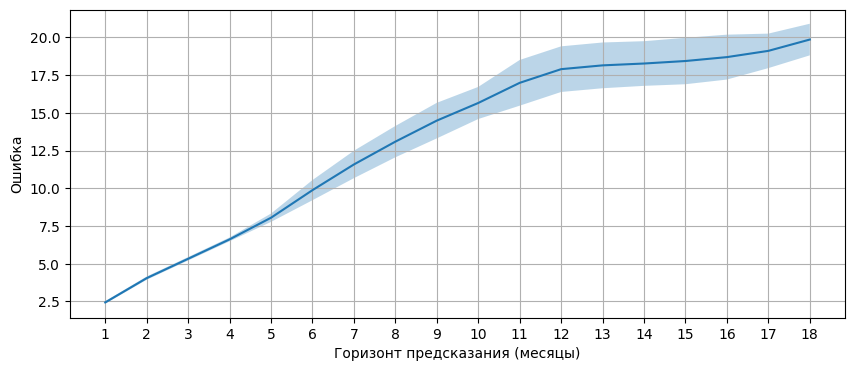

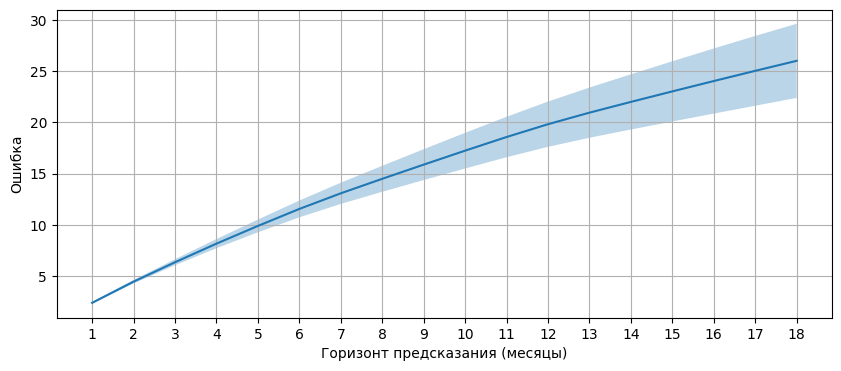

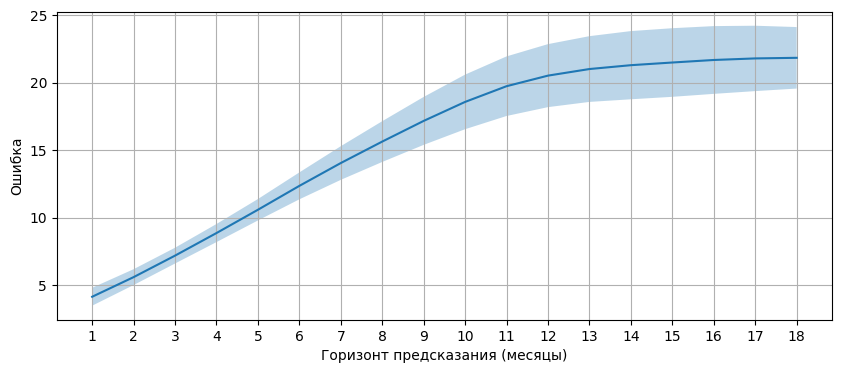

In [37]:
for means, std_rmses, title in zip([mean_rmses_x18[-1], mean_rmses_auto[-1], mean_rmses_18_forward[-1]],
                                   [stds_x18[-1], stds_auto[-1], stds_18_forward[-1]],
                                   ['x18', 'auto', '18-forward']):
    plot_err(means, std_rmses)
    plt.savefig(f'plots_article/err_{title}.png', format='png', dpi=400, bbox_inches='tight')
    # plt.title(title)
    plt.show()

In [14]:
rmses_linreg_auto = np.load('weights_and_data/rmses_linreg.npy')
rmses_linreg_18forward = np.load('weights_and_data/rmses_18forward.npy')
rmses_linreg_x18 = np.load('weights_and_data/rmses_x18.npy')

lin_rmses = [rmses_linreg_auto, rmses_linreg_x18, rmses_linreg_18forward]

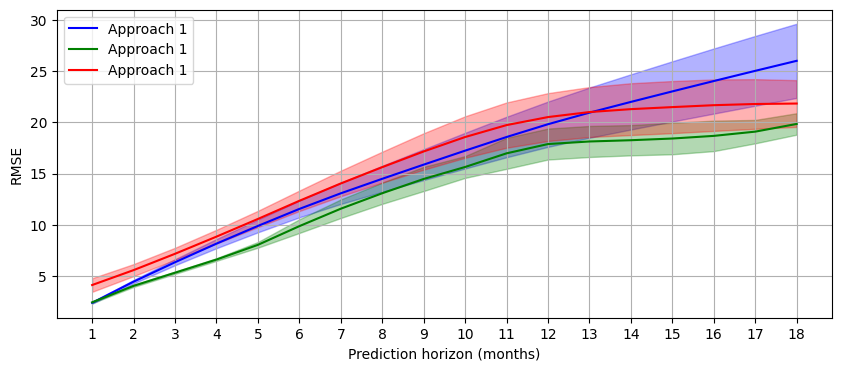

In [20]:
def plot_err_all(means_list, std_rmses_list, colors, linreg_rmses):
    plt.figure(figsize=(10, 4))
    i = 0
    for means, std_rmses, color in zip(means_list, std_rmses_list, colors):
        x_values = np.arange(1, 19)
        plt.plot(x_values, means, color=color, label=f'Approach {i+1}')
        plt.fill_between(x_values, means - std_rmses, means + std_rmses, alpha=0.3, color=color)
        
    
    plt.xlabel('Prediction horizon (months)')
    plt.ylabel('RMSE')
    plt.xticks(np.arange(1, 19, 1))
    plt.legend()
    plt.grid(True)
    plt.savefig('imgs/plots_article/en/combined_err_linreg.png', format='png', dpi=400, bbox_inches='tight')
    plt.show()
    

# Данные для всех трех графиков
means_list = [mean_rmses_auto[-1], mean_rmses_x18[-1], mean_rmses_18_forward[-1]]
std_rmses_list = [stds_auto[-1], stds_x18[-1], stds_18_forward[-1]]
colors = ['blue', 'green', 'red']

# Вызов функции для построения графика
plot_err_all(means_list, std_rmses_list, colors, lin_rmses)


In [23]:
rmses_linreg_x18[-1] * M

22.96688473597169

# Big plots

## auto

In [ ]:
import scripts

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
data_auto = scripts.DataAuto(model_series, observed_series, 4)
test_data_auto = data_auto.X[360:]
model = scripts.NARXAuto(
    input_size=2*4+1,
    hidden_sizes=[24],
    output_size=1,
    M=M
)
model.to(device)

path_to_weights = 'final/auto/models/'

steps = 18

preds100 = []

for i in tqdm(range(100)):
    model.load_state_dict(torch.load(os.path.join(path_to_weights, f'model_weights_{i}.pth')))
    model.eval()
    preds = []
    for j in range(len(test_data_auto) - steps):
        preds_auto = model.autoregressive_prediction(test_data_auto.to(device), j, steps)
        preds.append(preds_auto)
    preds100.append(preds)
all_preds = np.array(preds100)

100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


In [31]:
# save all_preds
np.save('autopreds.npy', all_preds)

## 18-forward

In [33]:
data_18_forward = scripts.Data18Forward(model_series, observed_series, 4, 18)
test_data_18_forward = data_18_forward.X[360:]
model = scripts.NARX18Forward(
    input_size=2*4+18,
    hidden_sizes=[24],
    output_size=18,
    M=M
)
model.to(device)

path_to_weights = 'final/18-forward/models/'

preds = []

for i in tqdm(range(100)):
    model.load_state_dict(torch.load(os.path.join(path_to_weights, f'model_weights_{i}.pth')))
    model.eval()
    preds.append(model(test_data_18_forward.to(device)).detach().cpu().numpy())
    
all_preds_18_forward = np.array(preds)

100%|██████████| 100/100 [00:01<00:00, 92.03it/s]


In [35]:
np.save('18forwardpreds.npy', all_preds_18_forward)

# x18

In [ ]:
data_x18 = []
for h in range(1, 19):
    data_x18.append(scripts.Datax18(model_series, observed_series, 4, h))
test_data_x18 = [data.X[360:] for data in data_x18]
models = [scripts.NARXx18(
    input_size=2*4+h,
    hidden_sizes=[24],
    output_size=1,
    M=M
) for h in range(1, 19)]
for model in models:
    model.to(device)
    
path_to_weights = 'final/x18/models/'

In [88]:
all_preds_x18 = []

for i in tqdm(range(100)):
    preds = []
    for j, model in enumerate(models):
        model.load_state_dict(torch.load(os.path.join(path_to_weights, f'model_weights_iter{i}_horizon{j+1}.pth')))
        model.eval()
        preds.append(model(test_data_x18[j].to(device)).detach().cpu().numpy())
    
    # Находим минимальный размер предсказания для текущей итерации
    min_length = min([pred.shape[0] for pred in preds])
    
    # Собираем массив размера (min_length, 18) из первых min_length элементов каждого предсказания
    iter_preds = np.array([pred[:min_length, 0] for pred in preds]).T  # Транспонируем для нужной формы (min_length, 18)
    
    all_preds_x18.append(iter_preds)

# Преобразуем к np.array после выполнения всех итераций
all_preds_x18 = np.array(all_preds_x18)  # Размер будет (100, min_length, 18)


100%|██████████| 100/100 [00:03<00:00, 26.27it/s]


In [63]:
np.save('x18preds.npy', all_preds_x18)

In [24]:
all_preds_auto = np.load('weights_and_data/autopreds.npy')
all_preds_18_forward = np.load('weights_and_data/18forwardpreds.npy')
all_preds_x18 = np.load('weights_and_data/x18preds.npy')

In [66]:
all_preds_auto.shape, all_preds_18_forward.shape, all_preds_x18.shape

((100, 266, 18), (100, 267, 18), (100, 267, 18))

In [67]:
observed_series[360:].shape

(288,)

In [ ]:
0, 28, 54, 112, 173, 232, 

In [ ]:
from ipywidgets import interact

@interact(n=(0, len(dates[360:]) - 18))
def plot_predictions(n):
    plt.figure(figsize=(10, 6))
    # observed
    plt.plot(dates[360:], observed_series[360:] * M, label='Наблюдательные данные', color='black')

    # auto preds from date n
    plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_auto.mean(0)[n] * M, label='Автопредсказания', color='blue')

    # 18-forward preds from date n
    plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_18_forward.mean(0)[n] * M, label='18-forward предсказания', color='red')

    # x18 preds from date n
    plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_x18.mean(0)[n] * M, label='x18 предсказания', color='green')

    plt.legend()
    plt.show()

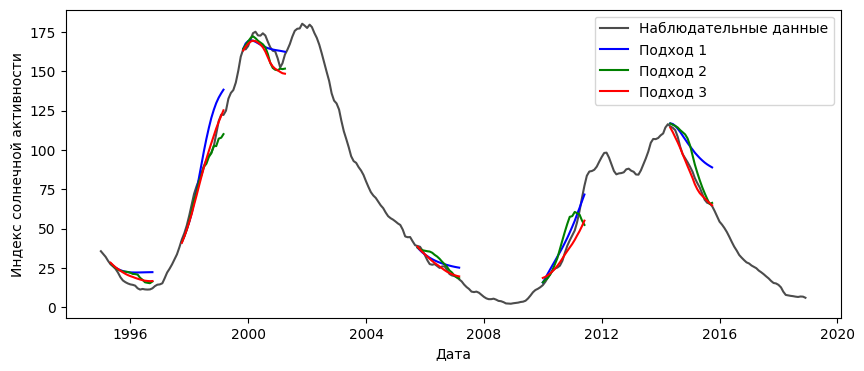

In [7]:
# Укажите значения n, для которых будут построены графики
n_values = [0, 29, 54, 125, 176, 228]

plt.figure(figsize=(10, 4))

# Отобразите наблюдательные данные
plt.plot(dates[360:], observed_series[360:] * M, label='Наблюдательные данные', color='black',  alpha=0.7)

# Построение предсказаний для каждого значения n
for i, n in enumerate(n_values):
    # Автопредсказания
    if i == 0:  # добавляем легенду только один раз для каждого типа предсказаний
        plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_auto.mean(0)[n] * M, label='Подход 1', color='blue')
        plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_x18.mean(0)[n] * M, label='Подход 2', color='green')
        plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_18_forward.mean(0)[n] * M, label='Подход 3', color='red')
    else:  # для остальных значений n не добавляем метки, чтобы не дублировать легенду
        plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_auto.mean(0)[n] * M, color='blue')
        plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_x18.mean(0)[n] * M, color='green')
        plt.plot(dates[360+n + 4:360+n+18 + 4], all_preds_18_forward.mean(0)[n] * M, color='red')

# Добавьте легенду и заголовок для графика
plt.legend()
# plt.title('Предсказания для разных значений n')

plt.xlabel('Дата')
plt.ylabel('Индекс солнечной активности')
plt.savefig('plots_article/preds.png', format='png', dpi=400, bbox_inches='tight')

# Показать график
plt.show()


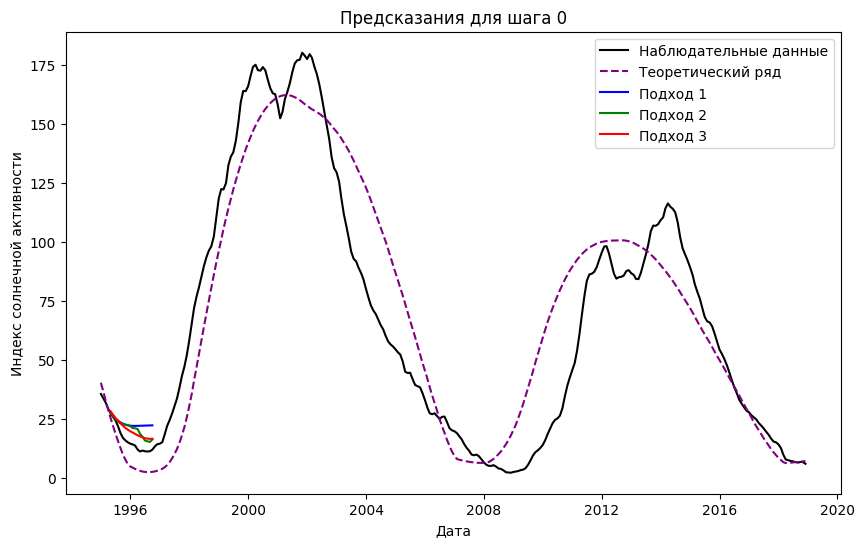

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# Параметры для анимации
n_values = range(0, 266)  # n меняется от 0 до 265

# Создаём фигуру и ось
fig, ax = plt.subplots(figsize=(10, 6))

# Настройка графика
ax.plot(dates[360:], observed_series[360:] * M, label='Наблюдательные данные', color='black')
# Теоретический ряд
ax.plot(dates[360:], model_series[360:] * M, label='Теоретический ряд', linestyle='--', color='purple')
line_auto, = ax.plot([], [], label='Подход 1', color='blue')
line_x18, = ax.plot([], [], label='Подход 2', color='green')
line_18_forward, = ax.plot([], [], label='Подход 3', color='red')
# x-axis name
ax.set_xlabel('Дата')
# y-axis name
ax.set_ylabel('Индекс солнечной активности')

ax.legend()

# Функция для обновления графика в каждом кадре
def update(n):
    # Автопредсказания
    line_auto.set_data(dates[360+n + 4:360+n+18 + 4], all_preds_auto.mean(0)[n] * M)
    # x18 предсказания
    line_x18.set_data(dates[360+n + 4:360+n+18 + 4], all_preds_x18.mean(0)[n] * M)
    # 18-forward предсказания
    line_18_forward.set_data(dates[360+n + 4:360+n+18 + 4], all_preds_18_forward.mean(0)[n] * M)

    ax.set_title(f'Предсказания для шага {n}')  # Обновление заголовка

# Создаём анимацию
ani = FuncAnimation(fig, update, frames=n_values, repeat=False)

# Сохраняем GIF
ani.save('predictions_animation.gif', writer=PillowWriter(fps=10))


In [26]:
mean_preds = [
    all_preds_auto.mean(0),
    all_preds_18_forward.mean(0)[:-1],
    all_preds_x18.mean(0)[:-1]
]

horizons = (1, 6, 18)

for m in mean_preds:
    print(m.shape)

(266, 18)
(266, 18)
(266, 18)


In [27]:
targets_1 = observed_series[360+4:360+4 + 266]
targets_6 = observed_series[360+4+6-1:360+4+6 + 266-1]
targets_18 = observed_series[360+4+18-1:360+4+18 + 266-1]

FileNotFoundError: [Errno 2] No such file or directory: 'plots_article/errors1618.png'

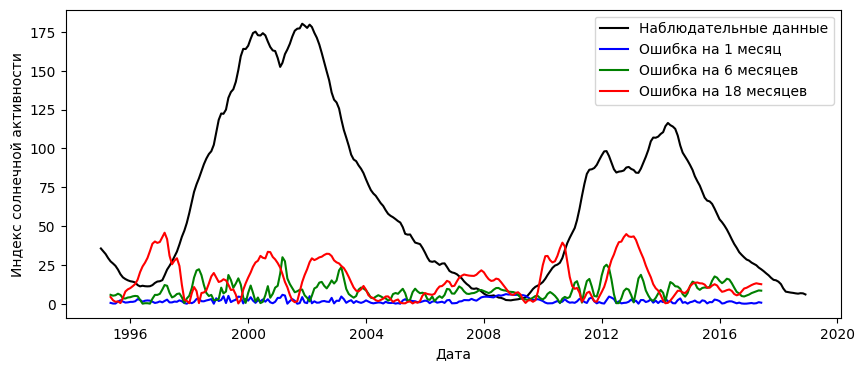

In [28]:
auto_preds_1 = mean_preds[2][:, 0] - targets_1
auto_preds_6 = mean_preds[2][:, 5] - targets_6
auto_preds_18 = mean_preds[2][:, 17] - targets_18


plt.figure(figsize=(10, 4))
plt.plot(dates[360:], observed_series[360:] * M, label='Наблюдательные данные', color='black')

plt.plot(dates[360+4:360+4 + 266], np.abs(auto_preds_1) * M, label='Ошибка на 1 месяц', color='blue')
plt.plot(dates[360+4:360+4+ + 266], np.abs(auto_preds_6) * M, label='Ошибка на 6 месяцев', color='green')
plt.plot(dates[360+4:360+4+ 266], np.abs(auto_preds_18) * M, label='Ошибка на 18 месяцев', color='red')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Индекс солнечной активности')
plt.savefig('plots_article/errors1618.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

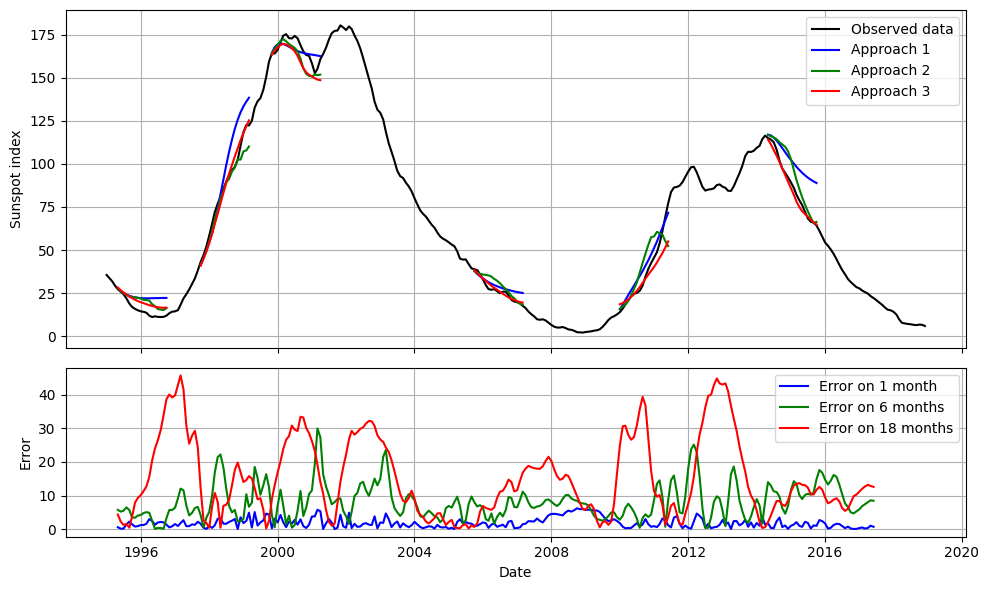

In [32]:
n_values = [0, 29, 54, 125, 176, 228]

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# First subplot: Predictions with different approaches
ax1.plot(dates[360:], observed_series[360:] * M, label='Observed data', color='black')

for i, n in enumerate(n_values):
    # Auto-predictions for each approach
    if i == 0:  # Only add legend once
        ax1.plot(dates[360+n + 4:360+n+18 + 4], all_preds_auto.mean(0)[n] * M, label='Approach 1', color='blue')
        ax1.plot(dates[360+n + 4:360+n+18 + 4], all_preds_x18.mean(0)[n] * M, label='Approach 2', color='green')
        ax1.plot(dates[360+n + 4:360+n+18 + 4], all_preds_18_forward.mean(0)[n] * M, label='Approach 3', color='red')
    else:
        ax1.plot(dates[360+n + 4:360+n+18 + 4], all_preds_auto.mean(0)[n] * M, color='blue')
        ax1.plot(dates[360+n + 4:360+n+18 + 4], all_preds_x18.mean(0)[n] * M, color='green')
        ax1.plot(dates[360+n + 4:360+n+18 + 4], all_preds_18_forward.mean(0)[n] * M, color='red')

# Configure the first subplot
ax1.legend()
ax1.set_ylabel('Sunspot index')
ax1.grid(True)  # Add grid to the first subplot

# Second subplot: Prediction errors
# ax2.plot(dates[360:], observed_series[360:] * M, label='Наблюдательные данные', color='black')
ax2.plot(dates[360+4:360+4 + 266], np.abs(auto_preds_1) * M, label='Error on 1 month', color='blue')
ax2.plot(dates[360+4:360+4 + 266], np.abs(auto_preds_6) * M, label='Error on 6 months', color='green')
ax2.plot(dates[360+4:360+4 + 266], np.abs(auto_preds_18) * M, label='Error on 18 months', color='red')

# Configure the second subplot
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Error')
ax2.grid(True)  # Add grid to the second subplot

# Adjust layout and show/save plot
plt.tight_layout()
plt.savefig('imgs/plots_article/en/combined_plot.png', format='png', dpi=400, bbox_inches='tight')
plt.show()